# Clip and Visualize GIS Data from National Levee Database

This notebook demonstrates how to clip the [NLD](https://levees.sec.usace.army.mil/#/) GIS data to a user-provided region and perform a quick visualization over clipped data. The official NLD map viewer privides data subset by county. However, for large scale research subsetting data by wateshed is more desirable. In this example, we use the [Ohio River Basin](https://www.sciencebase.gov/catalog/item/5033c153e4b068b9cdc5475e) to clip the NLD data.

We assume you have gone through the "1_NLD_Bulk_Download" notebook and have the full NLD GIS data donwloaded as shapefiles.

<img src="statics/images/NLD_subset_by_county.png" alt="drawing" width="600"/>

<img src="statics/images/NLD_subset_by_watershed.png" alt="drawing" width="600"/>

## Inspect original data

Here we import the libs we will be using

In [1]:
import os
import json
from ipyleaflet import Map, GeoData, basemaps, LayersControl, WidgetControl
from ipywidgets import Textarea
import geopandas as gpd
import matplotlib.pyplot as plt

We list all the NLD shapefiles we have downloaded in the the first notebook "1_NLD_Bulk_Download"

In [2]:
# the local folder that contains the original NLD shapefiles
download_folder = os.path.abspath("./download")
## or if you are on CyberGISX, use the following pre-downloaded NLD shapefiles
#download_folder = "/home/jovyan/shared_data/data/iguide/agingdam/NationalLeveeDatabase"
!ls {download_folder}/*.shp -alh 

-rw-r--r-- 1 jovyan users  89M Mar  9 22:03 /home/jovyan/work/National_Levee_Database/download/Alignment_Lines.shp
-rw-r--r-- 1 jovyan users 1.8M Mar 11 13:06 /home/jovyan/work/National_Levee_Database/download/Boreholes.shp
-rw-r--r-- 1 jovyan users 544K Mar  9 22:03 /home/jovyan/work/National_Levee_Database/download/Closure_Structures.shp
-rw-r--r-- 1 jovyan users 3.9M Mar  9 21:53 /home/jovyan/work/National_Levee_Database/download/Crossings.shp
-rw-r--r-- 1 jovyan users  82M Mar  9 22:05 /home/jovyan/work/National_Levee_Database/download/Cross_Sections.shp
-rw-r--r-- 1 jovyan users  81M Mar  9 22:08 /home/jovyan/work/National_Levee_Database/download/Embankments.shp
-rw-r--r-- 1 jovyan users 3.8M Mar  9 22:09 /home/jovyan/work/National_Levee_Database/download/Floodwalls.shp
-rw-r--r-- 1 jovyan users 4.3M Mar  9 22:09 /home/jovyan/work/National_Levee_Database/download/FRM_Lines.shp
-rw-r--r-- 1 jovyan users 2.0M Mar  9 22:10 /home/jovyan/work/National_Levee_Database/download/Gravity_Dr

Load a NLD layer and the user-provided area (Ohio river basin in this case) using geopandas

In [3]:
nld_shapefile_path = os.path.join(download_folder, "Leveed_Areas.shp")
features_gdf = gpd.read_file(nld_shapefile_path)
boundary_shp_path = "./boundary/FHP_Ohio_River_Basin_boundary.shp"
boundary_gdf = gpd.read_file(boundary_shp_path)

Quick plot the two layers

<AxesSubplot:>

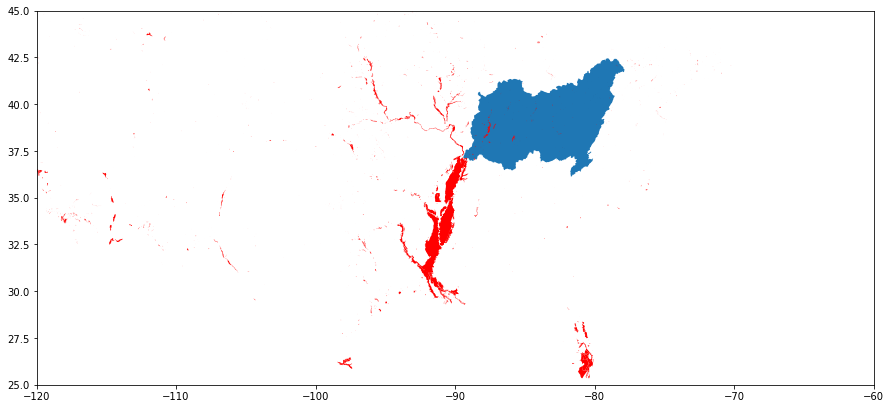

In [4]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xlim(-120, -60)
ax.set_ylim(25, 45)
boundary_gdf.plot(ax=ax)
features_gdf.plot(ax=ax, color="red")

## Subsetting

We check how many fearures exist in the original NLD layer

In [5]:
features_gdf.shape

(7147, 51)

### 1st Pass - Coarse spatial query using bounding box (RTree)

In [6]:
boundary_geom = boundary_gdf.iloc[0].geometry
clip_possible_gdf = features_gdf.iloc[features_gdf.sindex.query(boundary_geom)]
clip_possible_gdf.shape

(671, 51)

### 2nd Pass - Precise spatial query 

In [7]:
clip_exact_gdf = clip_possible_gdf[clip_possible_gdf.geometry.within(boundary_geom)]
clip_exact_gdf.shape

(343, 51)

### Save subset to a new shapefile

In [8]:
clipped_folder = os.path.abspath("./clipped")
!mkdir -p {clipped_folder}
nld_clipped_shp_path = os.path.join(clipped_folder, os.path.basename(nld_shapefile_path))
clip_exact_gdf.to_file(nld_clipped_shp_path)
!ls {clipped_folder} -alh

total 20M
drwxr-xr-x 2 jovyan users  150 Mar 14 02:18 .
drwxr-xr-x 8 jovyan users  228 Mar 14 02:18 ..
-rw-r--r-- 1 jovyan users   10 Mar 14 02:18 Leveed_Areas.cpg
-rw-r--r-- 1 jovyan users 1.3M Mar 14 02:18 Leveed_Areas.dbf
-rw-r--r-- 1 jovyan users  145 Mar 14 02:18 Leveed_Areas.prj
-rw-r--r-- 1 jovyan users  11M Mar 14 02:18 Leveed_Areas.shp
-rw-r--r-- 1 jovyan users 2.8K Mar 14 02:18 Leveed_Areas.shx


## Quick Interactive Visualization

Here we use ipyleaflet to perform a quick interactive visualization on the subset.

In [9]:
## Uncomment the codes below to simply geometry if subset is big and visualization is slow

# import shapely
# def row_func(row):
#     return shapely.wkb.loads(
#         shapely.wkb.dumps(row.geometry, output_dimension=2)).simplify(0.05)

# clip_exact_gdf = gpd.read_file(nld_clipped_shp_path)
# clip_exact_gdf["geometry"] = clip_exact_gdf.apply(row_func, axis=1)

In [11]:
m = Map(center=(52.3,8.0), zoom = 3, basemap= basemaps.Esri.WorldTopoMap)

features_data = GeoData(geo_dataframe = clip_exact_gdf,
                   style={'color': 'black', 'fillColor': 'red', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.8},
                   hover_style={'fillColor': 'yellow' , 'fillOpacity': 1},
                   name = 'Boundary')

boundary_data = GeoData(geo_dataframe = boundary_gdf,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':1, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.2},
                   name = 'Features')
m.fit_bounds([[boundary_gdf.bounds.miny[0], boundary_gdf.bounds.minx[0]], [boundary_gdf.bounds.maxy[0], boundary_gdf.bounds.maxx[0]]])
testarea = Textarea( value='Click on a feature to see attributes',
    placeholder='Type something',
    description='String:',
    disabled=True)
control = WidgetControl(widget=testarea, position='topright')
m.add_control(control)
def update_html(feature, **kwargs):
     testarea.value = '''
     {}
      '''.format(json.dumps(feature['properties'], indent=1))
features_data.on_click(update_html)

m.add_layer(boundary_data)
m.add_layer(features_data)
m.add_control(LayersControl())
m

Map(center=[52.3, 8.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

## References

https://stackoverflow.com/questions/57773092/how-to-plot-several-layers-using-geopandas

https://ipyleaflet.readthedocs.io/en/latest/

https://geopandas.org/en/stable/docs/reference/sindex.html

https://shapely.readthedocs.io/en/stable/manual.html